# Godzilla searching
## BTC price prediction using exchange data with bitcoin trxns outputs

In [1]:
import pandas as pd
import numpy as np
from StrFloatConvert import strtofloatconvert as str_flt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from normalization import norm
from SelectiveTranspose import selective_transpose as st


print('All libs are loaded!')

All libs are loaded!


In [2]:
PRACTICE_DS_SIZE = 45

In [3]:
raw_dataset = pd.read_csv('/Users/aaraybin/Documents/py4e/ML/Bitcoin/mysite/btc/data/prepared_ds_market-blckch(07-10_04-18).csv')
test_df = raw_dataset.copy()
test_df.tail(268)

,Price,Open,High,Low,Vol.,Change%,Date,out_sums
2573,0.9,0.8,0.9,0.8,48420.0,11.69,2011-04-12,146482.586558
2574,0.8,0.7,0.8,0.7,14650.0,0.00,2011-04-11,95112.652554
2575,0.7,0.7,0.8,0.7,5350.0,0.00,2011-04-10,93657.958689
2576,0.7,0.8,0.8,0.7,12120.0,0.00,2011-04-09,149397.080100
2577,0.8,0.8,0.8,0.7,18210.0,0.00,2011-04-08,136261.746054
...,...,...,...,...,...,...,...,...
2836,0.1,0.1,0.1,0.1,2400.0,0.00,2010-07-23,30314.790000
2837,0.1,0.1,0.1,0.1,2160.0,0.00,2010-07-22,48431.620000
2838,0.1,0.1,0.1,0.1,580.0,0.00,2010-07-21,38004.540000
2839,0.1,0.1,0.1,0.1,260.0,0.00,2010-07-20,38952.340000


In [4]:
zeroes = test_df.tail(267)
test_df = test_df.iloc[0:len(test_df)-len(zeroes)]
test_df

,Price,Open,High,Low,Vol.,Change%,Date,out_sums
0,9352.4,8940.8,9428.9,8895.5,199780.0,4.60,2018-04-28,9.809180e+05
1,8940.9,9282.8,9386.3,8920.2,184910.0,-3.73,2018-04-27,1.535703e+06
2,9287.0,8874.5,9303.6,8669.8,248390.0,4.67,2018-04-26,1.066988e+06
3,8873.1,9645.0,9753.1,8768.1,395670.0,-8.01,2018-04-25,1.975586e+06
4,9645.3,8952.7,9734.8,8937.0,260790.0,7.73,2018-04-24,1.771582e+06
...,...,...,...,...,...,...,...,...
2569,1.0,1.0,1.1,1.0,28870.0,6.07,2011-04-16,3.523740e+05
2570,1.0,1.0,1.1,0.9,50310.0,0.00,2011-04-15,1.078860e+05
2571,1.0,0.9,1.0,0.9,31110.0,8.40,2011-04-14,1.538320e+05
2572,0.9,0.9,1.0,0.9,43400.0,7.27,2011-04-13,1.876892e+05


In [5]:
#Making data more viable. In real live we don't know the OHLV on the end of the current day. 
#So we should delete the last OHLV and the first price to make df's the same lengths.
price = test_df.pop('Price')
price = price.drop(price.index[-1])

test_df = test_df.drop(test_df.index[0])

test_df.index = np.arange(len(test_df))
test_df = pd.concat((price,test_df), axis=1)

later_testds_for_plot = test_df.iloc[:PRACTICE_DS_SIZE]
test_df = test_df.iloc[len(later_testds_for_plot):]
test_df = test_df.reset_index(drop=True)
later_testds_for_plot

,Price,Open,High,Low,Vol.,Change%,Date,out_sums
0,9352.4,9282.8,9386.3,8920.2,184910.0,-3.73,2018-04-27,1.535703e+06
1,8940.9,8874.5,9303.6,8669.8,248390.0,4.67,2018-04-26,1.066988e+06
2,9287.0,9645.0,9753.1,8768.1,395670.0,-8.01,2018-04-25,1.975586e+06
3,8873.1,8952.7,9734.8,8937.0,260790.0,7.73,2018-04-24,1.771582e+06
4,9645.3,8809.3,9001.0,8785.3,147540.0,1.66,2018-04-23,1.097166e+06
5,8952.8,8923.6,9022.3,8766.5,161890.0,-1.30,2018-04-22,7.804803e+05
6,8806.7,8867.0,9027.7,8614.5,206010.0,0.63,2018-04-21,9.141617e+05
7,8923.1,8292.3,8926.2,8224.5,225960.0,6.95,2018-04-20,1.525188e+06
8,8867.0,8179.0,8303.7,8126.7,155080.0,1.37,2018-04-19,1.317694e+06
9,8290.8,7908.5,8227.6,7895.3,163260.0,3.41,2018-04-18,1.115698e+06


In [6]:
timestamps = test_df.pop('Date')
sum_outs = test_df.pop('out_sums')
test_df

,Price,Open,High,Low,Vol.,Change%
0,8210.6,9138.7,9482.0,8875.1,239460.0,0.19
1,9154.9,9535.8,9892.2,8804.1,257910.0,-4.12
2,9137.4,8732.2,9719.6,8516.4,266590.0,8.76
3,9529.6,9216.2,9500.0,8691.1,198730.0,-4.94
4,8762.0,9301.9,9420.5,8351.0,371460.0,-0.89
...,...,...,...,...,...,...
2523,1.1,1.0,1.1,1.0,28870.0,6.07
2524,1.0,1.0,1.1,0.9,50310.0,0.00
2525,1.0,0.9,1.0,0.9,31110.0,8.40
2526,1.0,0.9,1.0,0.9,43400.0,7.27


In [7]:
# Making train/test split
train = test_df.sample(frac=0.8, random_state=42)
test = test_df.drop(train.index)

#Setting targets
train_labels = train.pop('Price')
test_labels = test.pop('Price')

#Normalizing data
normed_train_data = norm(train, train)
normed_test_data = norm(train, test)

normed_train_data

,Open,High,Low,Vol.,Change%
1752,-0.373183,-0.371212,-0.376105,-0.630529,0.046730
748,-0.266932,-0.269582,-0.266570,0.084706,-0.001169
194,1.269482,1.255527,1.365771,0.180513,0.268896
1099,-0.314872,-0.313228,-0.314448,1.604188,-0.021551
1178,-0.299962,-0.302334,-0.301920,-0.675118,-0.307922
...,...,...,...,...,...
1683,-0.383332,-0.381789,-0.387301,-0.870212,-0.025628
2164,-0.420127,-0.417282,-0.425392,-0.367309,0.100743
2354,-0.420053,-0.417212,-0.425314,-0.844354,-0.069449
2149,-0.420053,-0.417177,-0.425314,0.158965,0.217941


In [8]:
len(train.keys())

5

In [9]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [BTC price]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,200])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$BTC price^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([36000,47000])
  plt.legend()
  plt.show()

class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

### Testing Neural Network without Txns Outputs

In [10]:
#Building model
#    layers.Dense(15, activation='relu', input_shape=[len(train.keys())]),
def build_reverse_vortex_model2():
    model = keras.Sequential([
    layers.Dense(32, activation='relu', input_shape=[len(train.keys())]),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1)
    ])
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model
reverse_vortex_model2 = build_reverse_vortex_model2()
reverse_vortex_model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                192       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 2,849
Trainable params: 2,849
Non-trainable params: 0
_________________________________________________________________



.......................................

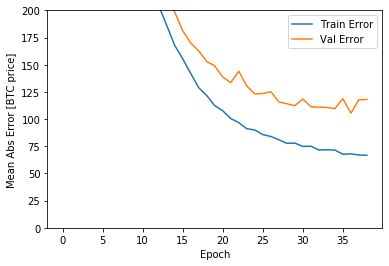

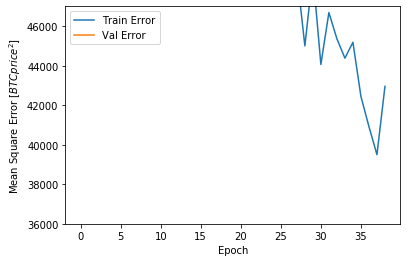

In [11]:
#Model learning
#Using early stopping callback

EPOCHS = 500

# Patience parameter describes epoch amount testing on improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = reverse_vortex_model2.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [12]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
34,45182.397689,71.492165,45182.398438,131022.068586,109.647865,131022.06250,34
35,42444.093774,67.680443,42444.089844,160252.043924,118.753059,160252.06250,35
36,40917.712935,68.035278,40917.710938,130913.151365,105.435028,130913.15625,36
37,39499.058747,66.950668,39499.062500,164022.850579,117.757629,164022.84375,37
38,42950.445130,66.671539,42950.437500,167073.602681,118.032677,167073.59375,38


In [13]:
loss, mae, mse = reverse_vortex_model2.evaluate(normed_test_data, test_labels, verbose=2)

print("\nTesting set Mean Abs Error: {:5.2f} USD".format(mae))

506/506 - 0s - loss: 36201.9241 - mae: 66.5216 - mse: 36201.9219

Testing set Mean Abs Error: 66.52 USD


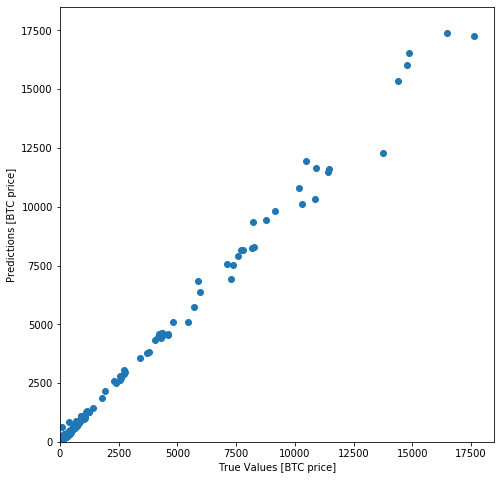

In [14]:
#Making prognosis
test_predictions = reverse_vortex_model2.predict(normed_test_data).flatten()

plt.figure(figsize=(10,8))
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [BTC price]')
plt.ylabel('Predictions [BTC price]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

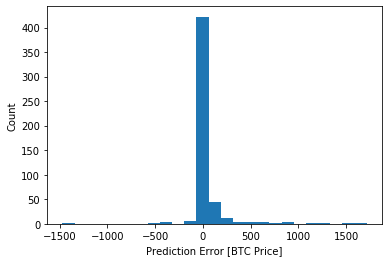

In [15]:
#Error distribution
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [BTC Price]")
_ = plt.ylabel("Count")

In [16]:
later_testds_for_plot.head(2)

,Price,Open,High,Low,Vol.,Change%,Date,out_sums
0,9352.4,9282.8,9386.3,8920.2,184910.0,-3.73,2018-04-27,1.535703e+06
1,8940.9,8874.5,9303.6,8669.8,248390.0,4.67,2018-04-26,1.066988e+06


In [17]:
actual_price = later_testds_for_plot.pop('Price')
actual_dates = later_testds_for_plot.pop('Date')
actual_out_sums = later_testds_for_plot.pop('out_sums')
normed_practice_data = norm(train, later_testds_for_plot)

In [18]:
practice_prediction = reverse_vortex_model2.predict(normed_practice_data).flatten()
practice_prediction

array([9621.769 , 9463.692 , 9771.735 , 9778.637 , 9362.6   , 9360.023 ,
       9301.147 , 9006.909 , 8663.56  , 8484.51  , 8432.112 , 8601.926 ,
       8632.749 , 8417.482 , 8389.716 , 7839.7764, 7287.5996, 7169.011 ,
       7265.835 , 7383.4404, 7191.8604, 7051.903 , 7128.446 , 7443.435 ,
       7653.477 , 7330.6904, 7142.4824, 7352.1123, 7396.191 , 7892.5107,
       8338.023 , 8402.637 , 8643.98  , 8983.221 , 9216.782 , 9109.347 ,
       9254.134 , 9422.567 , 9139.689 , 8851.785 , 8282.829 , 8450.89  ,
       8688.696 , 8534.027 , 9096.3545], dtype=float32)

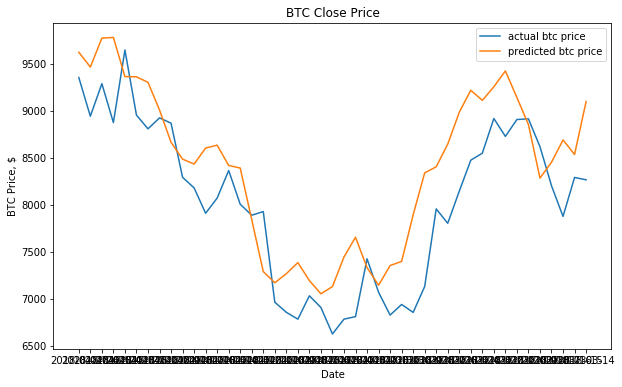

In [19]:
plt.figure(figsize=(10,6))
plt.plot(actual_dates,actual_price, label ='actual btc price')
plt.plot(actual_dates,practice_prediction, label ='predicted btc price')
plt.xlabel('Date')
plt.ylabel('BTC Price, $')
plt.title('BTC Close Price')
plt.legend()
plt.show()

### Testing NN with out_sums dimention

In [20]:
raw_dataset2 = pd.read_csv('/Users/aaraybin/Documents/py4e/ML/Bitcoin/mysite/btc/data/prepared_ds_market-blckch(07-10_04-18).csv')
test_df2 = raw_dataset2.copy()
zeroes = test_df2.tail(267)
test_df2 = test_df2.iloc[0:len(test_df2)-len(zeroes)]
test_df2

,Price,Open,High,Low,Vol.,Change%,Date,out_sums
0,9352.4,8940.8,9428.9,8895.5,199780.0,4.60,2018-04-28,9.809180e+05
1,8940.9,9282.8,9386.3,8920.2,184910.0,-3.73,2018-04-27,1.535703e+06
2,9287.0,8874.5,9303.6,8669.8,248390.0,4.67,2018-04-26,1.066988e+06
3,8873.1,9645.0,9753.1,8768.1,395670.0,-8.01,2018-04-25,1.975586e+06
4,9645.3,8952.7,9734.8,8937.0,260790.0,7.73,2018-04-24,1.771582e+06
...,...,...,...,...,...,...,...,...
2569,1.0,1.0,1.1,1.0,28870.0,6.07,2011-04-16,3.523740e+05
2570,1.0,1.0,1.1,0.9,50310.0,0.00,2011-04-15,1.078860e+05
2571,1.0,0.9,1.0,0.9,31110.0,8.40,2011-04-14,1.538320e+05
2572,0.9,0.9,1.0,0.9,43400.0,7.27,2011-04-13,1.876892e+05


In [21]:
#Making data more viable. In real live we don't know the OHLV on the end of the current day. 
#So we should delete the last OHLV and the first price to make df's the same lengths.
price2 = test_df2.pop('Price')
price2 = price2.drop(price2.index[-1])

test_df2 = test_df2.drop(test_df2.index[0])

test_df2.index = np.arange(len(test_df2))
test_df2 = pd.concat((price2,test_df2), axis=1)

later_testds_for_plot2 = test_df2.iloc[:PRACTICE_DS_SIZE]
test_df2 = test_df2.iloc[len(later_testds_for_plot2):]
test_df2 = test_df2.reset_index(drop=True)

later_testds_for_plot2

,Price,Open,High,Low,Vol.,Change%,Date,out_sums
0,9352.4,9282.8,9386.3,8920.2,184910.0,-3.73,2018-04-27,1.535703e+06
1,8940.9,8874.5,9303.6,8669.8,248390.0,4.67,2018-04-26,1.066988e+06
2,9287.0,9645.0,9753.1,8768.1,395670.0,-8.01,2018-04-25,1.975586e+06
3,8873.1,8952.7,9734.8,8937.0,260790.0,7.73,2018-04-24,1.771582e+06
4,9645.3,8809.3,9001.0,8785.3,147540.0,1.66,2018-04-23,1.097166e+06
5,8952.8,8923.6,9022.3,8766.5,161890.0,-1.30,2018-04-22,7.804803e+05
6,8806.7,8867.0,9027.7,8614.5,206010.0,0.63,2018-04-21,9.141617e+05
7,8923.1,8292.3,8926.2,8224.5,225960.0,6.95,2018-04-20,1.525188e+06
8,8867.0,8179.0,8303.7,8126.7,155080.0,1.37,2018-04-19,1.317694e+06
9,8290.8,7908.5,8227.6,7895.3,163260.0,3.41,2018-04-18,1.115698e+06


In [22]:
timestamps2 = test_df2.pop('Date')
test_df2

,Price,Open,High,Low,Vol.,Change%,out_sums
0,8210.6,9138.7,9482.0,8875.1,239460.0,0.19,1.602214e+06
1,9154.9,9535.8,9892.2,8804.1,257910.0,-4.12,1.019469e+06
2,9137.4,8732.2,9719.6,8516.4,266590.0,8.76,7.840761e+05
3,9529.6,9216.2,9500.0,8691.1,198730.0,-4.94,6.258901e+05
4,8762.0,9301.9,9420.5,8351.0,371460.0,-0.89,1.207456e+06
...,...,...,...,...,...,...,...
2523,1.1,1.0,1.1,1.0,28870.0,6.07,3.523740e+05
2524,1.0,1.0,1.1,0.9,50310.0,0.00,1.078860e+05
2525,1.0,0.9,1.0,0.9,31110.0,8.40,1.538320e+05
2526,1.0,0.9,1.0,0.9,43400.0,7.27,1.876892e+05


In [23]:
# Making train/test split
train2 = test_df2.sample(frac=0.8, random_state=42)
test2 = test_df2.drop(train2.index)

#Setting targets
train_labels2 = train2.pop('Price')
test_labels2 = test2.pop('Price')

#Normalizing data
normed_train_data2 = norm(train2, train2)
normed_test_data2 = norm(train2, test2)

normed_train_data2

,Open,High,Low,Vol.,Change%,out_sums
1752,-0.373183,-0.371212,-0.376105,-0.630529,0.046730,-0.657915
748,-0.266932,-0.269582,-0.266570,0.084706,-0.001169,0.865987
194,1.269482,1.255527,1.365771,0.180513,0.268896,-0.007301
1099,-0.314872,-0.313228,-0.314448,1.604188,-0.021551,-0.313757
1178,-0.299962,-0.302334,-0.301920,-0.675118,-0.307922,-0.395540
...,...,...,...,...,...,...
1683,-0.383332,-0.381789,-0.387301,-0.870212,-0.025628,-0.524108
2164,-0.420127,-0.417282,-0.425392,-0.367309,0.100743,-0.075677
2354,-0.420053,-0.417212,-0.425314,-0.844354,-0.069449,-0.688782
2149,-0.420053,-0.417177,-0.425314,0.158965,0.217941,-0.490231


In [24]:
def plot_history2(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [BTC price]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,200])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$BTC price^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([36000,47000])
  plt.legend()
  plt.show()

class PrintDot2(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

In [25]:
#Building model
#    layers.Dense(15, activation='relu', input_shape=[len(train.keys())]),
def build_model():
    model = keras.Sequential([
    layers.Dense(32, activation='relu', input_shape=[len(train2.keys())]),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1)
    ])
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model
model = build_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 32)                224       
_________________________________________________________________
dense_6 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_7 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_8 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 17        
Total params: 2,881
Trainable params: 2,881
Non-trainable params: 0
_________________________________________________________________



.........................................................

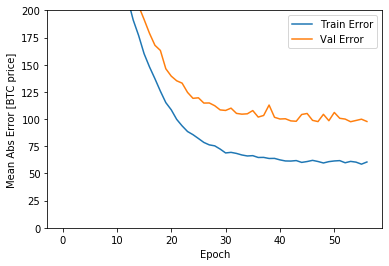

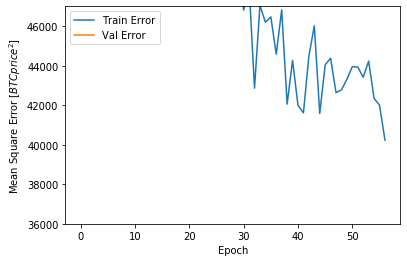

In [26]:
#Model learning
#Using early stopping callback

EPOCHS = 500

# Patience parameter describes epoch amount testing on improvement
early_stop2 = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history2 = model.fit(normed_train_data2, train_labels2, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop2, PrintDot2()])

plot_history(history2)

In [27]:
hist2 = pd.DataFrame(history2.history)
hist2['epoch'] = history2.epoch
hist2.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
52,43414.238960,59.815502,43414.242188,137180.021875,99.999100,137180.031250,52
53,44232.140723,61.084625,44232.144531,132294.803979,97.566322,132294.796875,53
54,42342.766970,60.388214,42342.757812,135180.053935,98.724777,135180.062500,54
55,42005.866215,58.542339,42005.863281,139002.310494,99.905884,139002.312500,55
56,40233.848931,60.523479,40233.855469,131184.851350,97.792397,131184.859375,56


In [28]:
loss, mae, mse = model.evaluate(normed_test_data2, test_labels2, verbose=2)

print("\nTesting set Mean Abs Error: {:5.2f} USD".format(mae))

506/506 - 0s - loss: 24382.0926 - mae: 48.5508 - mse: 24382.0918

Testing set Mean Abs Error: 48.55 USD


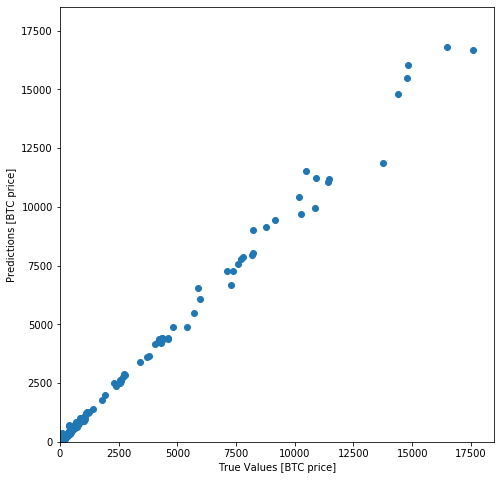

In [29]:
#Making prognosis
test_predictions2 = model.predict(normed_test_data2).flatten()

plt.figure(figsize=(10,8))
plt.scatter(test_labels2, test_predictions2)
plt.xlabel('True Values [BTC price]')
plt.ylabel('Predictions [BTC price]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

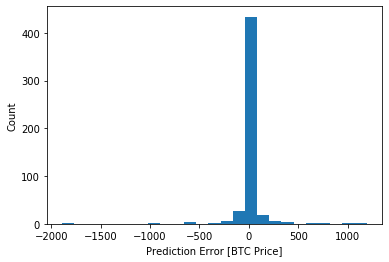

In [30]:
#Error distribution
error = test_predictions2 - test_labels2
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [BTC Price]")
_ = plt.ylabel("Count")

In [31]:
actual_price2 = later_testds_for_plot2.pop('Price')
actual_dates2 = later_testds_for_plot2.pop('Date')
normed_practice_data2 = norm(train2, later_testds_for_plot2)

In [32]:
practice_prediction2 = model.predict(normed_practice_data2).flatten()
practice_prediction2

array([9255.592 , 9118.202 , 9445.592 , 9433.442 , 9008.441 , 8996.596 ,
       8947.778 , 8677.757 , 8330.928 , 8153.9663, 8096.613 , 8268.684 ,
       8296.777 , 8081.597 , 8081.251 , 7605.809 , 6995.994 , 6882.246 ,
       6972.368 , 7087.502 , 6891.828 , 6759.5894, 6842.4805, 7141.4688,
       7361.471 , 7046.293 , 6859.287 , 7054.8105, 7126.4404, 7585.855 ,
       8007.8857, 8070.7427, 8324.232 , 8634.047 , 8848.759 , 8769.29  ,
       8900.442 , 9060.804 , 8802.591 , 8546.009 , 8013.794 , 8134.3193,
       8354.376 , 8252.642 , 8743.306 ], dtype=float32)

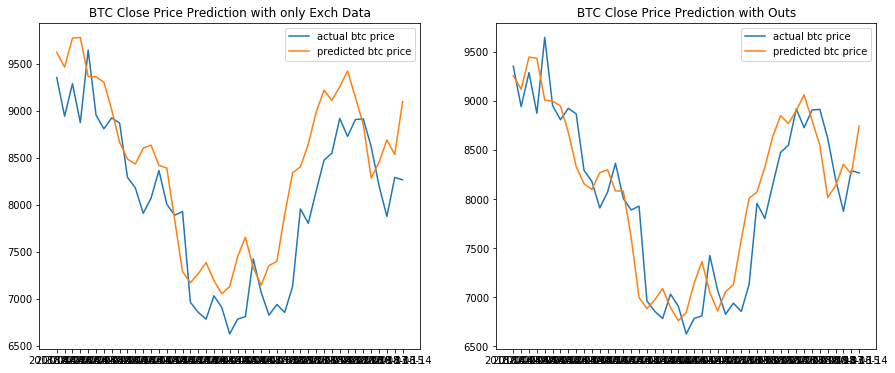

In [34]:
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.plot(actual_dates,actual_price, label ='actual btc price')
ax1.plot(actual_dates,practice_prediction, label ='predicted btc price')
ax1.set_title('BTC Close Price Prediction with only Exch Data')
ax1.legend()

ax2.plot(actual_dates2,actual_price2, label ='actual btc price')
ax2.plot(actual_dates2,practice_prediction2, label ='predicted btc price')
ax2.set_title('BTC Close Price Prediction with Outs')
ax2.legend()